In [ ]:
# Install required packages.
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
!pip install -q torch-geometric
!pip install -q ogb>=1.3.0

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from time import time

from google.colab import widgets
from ipywidgets import interact, interact_manual, FloatSlider
import pandas as pd
import numpy as np
import torch

     |████████████████████████████████| 2.6MB 10.7MB/s 
     |████████████████████████████████| 1.5MB 7.2MB/s 
     |████████████████████████████████| 194kB 8.2MB/s 
     |████████████████████████████████| 235kB 15.5MB/s 
     |████████████████████████████████| 2.2MB 9.8MB/s 
     |████████████████████████████████| 51kB 7.4MB/s 


In [ ]:
# THIS CELL WILL DISAPPEAR SINCE IT WLL BE MOVED TO EXTERNAL SCRIPT

# DEFINE VISUALIZATION FUNCTIONS
import networkx as nx  # Graph manipulation library
from torch_geometric.utils import to_networkx  # Conversion function

def to_molecule(torch_graph, remove_isolated=True):
    G = to_networkx(
        torch_graph,
        to_undirected=True,
        node_attrs=["symbols"]
    )
    return G


def plot_mol(
    G: nx.Graph,
    edge_mask=None,
    edge_type=None,
    threshold=None,
    drop_isolates=None,
    ax=None
):
    if drop_isolates is None:
        drop_isolates = True if threshold else False
    if ax is None:
        fig, ax = plt.subplots(dpi=120)

    pos = nx.planar_layout(G)
    pos = nx.kamada_kawai_layout(G, pos=pos)

    if edge_type is None:
        widths = None
    else:
        widths = edge_type + 1

    edgelist = G.edges()

    if edge_mask is None:
        edge_color = 'black'
    else:
        if threshold is not None:
            edgelist = [
                (u,v) for u, v in G.edges() if edge_mask[(u,v)] > threshold
            ]

        edge_color = [edge_mask[(u, v)] for u, v in edgelist]
    
    nodelist = G.nodes()
    if drop_isolates:
        if not edgelist:  # Prevent errors
            print("No nodes left to show !")
            return

        nodelist = list(set.union(*map(set,edgelist)))

    node_labels = {
        node: data["symbols"] for node, data in G.nodes(data=True)
        if node in nodelist
    }

    nx.draw_networkx(
        G, pos=pos,
        nodelist=nodelist,
        node_size=200,
        labels=node_labels,
        width=widths,
        edgelist=edgelist,
        edge_color=edge_color, edge_cmap=plt.cm.Blues,
        edge_vmin=0., edge_vmax=1.,
        node_color='azure',
        ax=ax
    )

    if ax is None:
        fig.tight_layout()
        plt.show()


def compute_accuracy(model, loader):
    model.eval()

    y_preds = []
    y_trues = []

    for data in loader:  # Iterate in batches over the training/test dataset.
        data.to(device)
        out = model(data.x, data.edge_index, data.batch)
        y_preds.append(out.argmax(dim=1))  # Use the class with highest probability.
        y_trues.append(data.y)  # Check against ground-truth labels.
    
    y_pred = torch.cat(y_preds).flatten()
    y_true = torch.cat(y_trues).flatten()

    return torch.sum(y_pred == y_true).item() / len(y_true)  # Derive ratio of correct predictions.

def plot_cm(cm, display_labels=["Mutag", "Non Mutag"]):
  # Set fontsize for plots
  font = {"size": 20}
  matplotlib.rc("font", **font)

  # Plot confusion matrix
  f, axes = plt.subplots(1, 1, figsize=(7, 7), sharey="row")
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
  disp.plot(ax=axes, xticks_rotation=45, cmap="Blues", values_format='d')
  disp.im_.colorbar.remove()
  disp.ax_.set_xlabel("Predicted label", fontsize=20)
  disp.ax_.set_ylabel("True label", fontsize=20)

def compute_cm(model, loader_test):
  with torch.no_grad():
      model.eval()
      test_batch = next(iter(loader_test)).to(device)

      y_pred = model(test_batch.x, test_batch.edge_index, test_batch.batch).argmax(dim=1)
      y_true = test_batch.y

  # Compute confusion matrix
  cm = confusion_matrix(y_true.flatten().cpu(), y_pred.cpu())

  return cm


from math import sqrt
from torch_geometric.nn import MessagePassing
EPS = 1e-15


class GNNExplainer(torch.nn.Module):
    """The GNN-Explainer model from the `"GNNExplainer: Generating
    Explanations for Graph Neural Networks"
    <https://arxiv.org/abs/1903.03894>`_ paper for identifying compact subgraph
    structures and small subsets node features that play a crucial role in a
    GNN’s graph-prediction.
    """

    coeffs = {
        'edge_size': 0.1,
        'node_feat_size': 1.0,
        'edge_ent': 1.0,
        'node_feat_ent': 0.1,
    }

    def __init__(self, model, epochs=100, lr=0.01, log=True):
        """ Initialize GNNExplainer Class.

        Args:
            model (torch.nn.Module): The GNN module to explain.
            epochs (int, optional): The number of epochs to train.
                (default: :obj:`100`)
            lr (float, optional): The learning rate to apply.
                (default: :obj:`0.01`)
        """
        super(GNNExplainer, self).__init__()
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.log = log

    def __set_masks__(self, x, edge_index):
        """ Initialize the masks for edges and node features.

        For each module contained in the GNN model, the attribute
        __edge_mask__ is set to the initialized edge mask, so that
        this is automatically taken into account during message passing.

        Args:
            x (torch tensor): node features
            edge_index (torch tensor): pytorch geometric edge index
        """
        (N, F), E = x.size(), edge_index.size(1)

        # Node feature mask.
        self.node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)

        # Edge mask.
        std = torch.nn.init.calculate_gain('relu') * sqrt(2.0 / (2 * N))
        self.edge_mask = torch.nn.Parameter(torch.randn(E) * std)

        # TODO: at some point we should enforce the mask to be symmetric?
        # Maybe do this iteratively in explain graph? --> but then should
        # maybe reset the module.__edge_mask__ as below

        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = True
                module.__edge_mask__ = self.edge_mask

    def __clear_masks__(self):
        """Deletes the node and edge masks.
        """
        for module in self.model.modules():
            if isinstance(module, MessagePassing):
                module.__explain__ = False
                module.__edge_mask__ = None
        self.node_feat_masks = None
        self.edge_mask = None

    def graph_loss(
        self,
        x: torch.tensor,
        edge_index: torch.tensor,
        batch_index: torch.tensor,
        expl_label: int,
        **kwargs
    ) -> torch.tensor:
        """Computes the explainer loss function for explanation
        of graph classificaiton tasks.

        Returns:
            loss (torch.tensor): explainer loss function, which
                is a weight sum of different terms.
        """
        # Mask node features
        h = x * self.node_feat_mask.view(1,-1).sigmoid()

        # Compute model output
        model_pred = self.model(h, edge_index, batch_index, **kwargs)
        pred_proba = torch.softmax(model_pred, 1)

        # Prediction loss.
        loss = -torch.log(pred_proba[:, expl_label])

        # Edge mask size loss.
        edge_mask = self.edge_mask.sigmoid()
        loss = loss + self.coeffs['edge_size'] * edge_mask.sum()

        # Edge mask entropy loss.
        ent = -edge_mask * torch.log(edge_mask + EPS) - (1 - edge_mask) * torch.log(1 - edge_mask + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()

        # Feature mask size loss.
        feat_mask = self.node_feat_mask.sigmoid()
        loss = loss + self.coeffs['node_feat_size'] * feat_mask.mean()

        return loss.sum()

    def explain_graph(self, x, edge_index, batch_index, expl_label: int, **kwargs):
        """Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for graph
        classification.

        Args:
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            batch_index (LongTensor): The batch index.
            expl_label (int): Label against which compute cross entropy

            **kwargs (optional): Additional arguments passed to the GNN module.

        Returns:
            (torch.tensor, torch.tensor): the node feature mask and edge mask
        """

        # if len(data.y) > 1:
        #     raise NotImplementedError(f"Can only explain one molecule, recieved {len(data.y)}")

        self.model.eval()
        self.__clear_masks__()

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        optimizer = torch.optim.Adam([self.node_feat_mask, self.edge_mask],
                                     lr=self.lr)

        for epoch in range(self.epochs):
            optimizer.zero_grad()

            loss = self.graph_loss(x, edge_index, batch_index, expl_label, **kwargs)
            loss.backward()

            optimizer.step()

        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        edge_mask = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        return node_feat_mask, edge_mask

from matplotlib.colorbar import ColorbarBase
from mpl_toolkits.axes_grid1 import make_axes_locatable

def explain_graph_visualized(data):
    data.to(device)
    x = data.x
    edge_index = data.edge_index
    model.eval()

    # Initialize explainer
    explainer = GNNExplainer(model, epochs=200).to(device)
    # Train explainer
    model_args = (data.x, data.edge_index, data.batch)
    GNNExp_feat_mask, GNNExp_edge_mask = explainer.explain_graph(
        *model_args,
        model(*model_args).argmax(dim=1)
    )

    mol = to_molecule(data)

    GNNExp_edge_mask_dict = mask_to_dict(
       GNNExp_edge_mask,
       data
    )

    fig, ax = plt.subplots(
        1, 2,
        sharex=True,
        sharey=True,
        dpi=150, figsize=(10,4)
    )

    fig.tight_layout()

    plot_mol(
        mol,
        edge_type=(data.edge_attr.argmax(dim=1) + 1).to("cpu").numpy(),
        ax=ax[1]
    )
    
    divider = make_axes_locatable(ax[0])
    cax = divider.append_axes("left", "4%", pad="1%")
    cbar = ColorbarBase(
        ax=cax, cmap=plt.cm.Blues,
        ticklocation="left",
    )

    def threshold_plot(threshold):
        xlim, ylim = ax[0].get_xlim(), ax[0].get_ylim()
        ax[0].clear()
        ax[0].set_xlim(xlim), ax[0].set_ylim(ylim)
        
        plot_mol(
            mol,
            GNNExp_edge_mask_dict,
            edge_type=(data.edge_attr.argmax(dim=1) + 1).to("cpu").numpy(),
            threshold=threshold,
            ax=ax[0]
        )

        cbar.add_lines([threshold], [[1, .5, 0, 1]], 3)

        display(fig)

    plt.close()

    return interact(
        threshold_plot,
        threshold=FloatSlider(value=0.1, min=0., max=.99, step=0.05)
    )


def big_interact(which):
    idces = []
    test_size = len(y_true)
    if which == "true_pos":
        idces += [
            i for i in range(test_size)
            if y_pred[i] == y_true[i] == 0
        ]
    if which == "true_neg":
        idces += [
            i for i in range(test_size)
            if y_pred[i] == y_true[i] == 1
        ]
    if which == "false_neg":
        idces += [
            i for i in range(test_size)
            if y_pred[i] != y_true[i] == 0
        ]
    if which == "false_pos":
        idces += [
            i for i in range(test_size)
            if y_pred[i] != y_true[i] == 1
        ]

    single_loader_te = DataLoader(
        dataset[idx_val:], batch_size=1, shuffle=False
    )

    
    return interact(
        lambda data: explain_graph_visualized(data),
        data=[graph for i, graph in enumerate(list(single_loader_te)) if i in idces],
    )

from collections import defaultdict

def mask_to_dict(edge_mask, data):
    """
    Conver an `edge_mask` in pytorch geometric format to a networkx compatible
    dictionary (_{(n1, n2) : mask_value}_).
    Multiple edge appearences are averaged.
    """
    edge_mask_dict = defaultdict(float)
    counts = defaultdict(int)

    for val, u, v in zip(edge_mask.to("cpu").numpy(), *data.edge_index):
        u, v = u.item(), v.item()
        if u > v:
            u, v = v, u
        edge_mask_dict[(u, v)] += val
        counts[(u,v)] += 1

    for edge, count in counts.items():
        edge_mask_dict[edge] /= count

    return edge_mask_dict


# Shedding light on obscure graph deep learning

Deep learning techniques on graphs have achieved impressive results in recent years. Graph neural networks (GNN) combine node feature information with the graph structure in order to make their predictions. However, this strategy results in complex models, whose predictions can be hard to interpret.

In this workshop, you will get familiar with graph data and you will learn the fundamental concepts behind graph neural networks. After building and training your own GNN, you'll be introduced to GNNExplainer, a model-agnostic framework for interpreting GNN results. Thus, you will be able to visualize explanations for your GNN's predictions, giving a sense to the model outputs.

# Working with graphs in PyTorch Geometric

Graphs are a powerful means to represent many real word data that contain structure. A graph is a pair $G=(V, E)$, where $V$ is a set of elements called vertices (or nodes) and $E$ is a set of edges (links), where an edge is an ordered pair of vertices. This way, edges represent relations among nodes.

We will be working with [PyTorch Geometric][1], a useful extension of pyTorch designed to work with graphs. A single graph in PyTorch Geometric is described by an instance of `torch_geometric.data.Data`, which can hold several attributes, among which:

* `data.x`: Node feature matrix with shape `[num_nodes, num_node_features]`

* `data.edge_index`: Graph connectivity tensor with shape `[2, num_edges]` and type torch.long. Note that one would expect the **node pairs** to be saved as rows, but in this format they are **saved as columns** of the `edge_index` matrix.

* `data.edge_attr`: Edge feature matrix with shape `[num_edges, num_edge_features]`

* `data.y`: Target to train against, e.g., node-level targets of shape `[num_nodes, *]` or graph-level targets of shape `[1, *]`

Not all of these fields should be present and the user can define his own attributes. The following cell shows an example for the creation of a simple graph in PyTorch Geometric.

[1]: https://pytorch-geometric.readthedocs.io/en/latest/


In [ ]:
import torch
from torch_geometric.data import Data

edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

G1 = Data(x=x, edge_index=edge_index)

## Exercise 1
In order to familiarize yourself with PyTorch Geometric, complete the implementation of the following function, which takes a graph as input (i.e. a `torch_geometric.data.Data` object), and returns `True` if the graph is **un**directed, `False` if it is directed. We say that a graph is undirected if for each existing edge $(i, j)$ there exists also the edge in the opposite direction, $(j,i)$. For simplicity, you may assume that the graph is connected (there are no isolated nodes) and there are no self loops.

In [ ]:
def is_undirected(graph):
  ## TODO: implement me!
  pass

In [ ]:
# Solution (TO BE REMOVED)
def is_undirected(graph):
  pair_dict = {}
  for edge_idx in range(graph.edge_index.shape[1]):
    if graph.edge_index[0, edge_idx] < graph.edge_index[1, edge_idx]:
      key = (int(graph.edge_index[0, edge_idx]), int(graph.edge_index[1, edge_idx]))
    else:
      key = (int(graph.edge_index[1, edge_idx]), int(graph.edge_index[0, edge_idx]))
    if key in pair_dict.keys():
      pair_dict[key] -= 1
    else:
      pair_dict[key] = 1
  return not bool(np.sum(list(pair_dict.values())))



Now verify the correctness of the function you wrote by comparing the results with the available PyTorch Geometric `is_directed()` method.

In [ ]:
print("Your function works correctly on G1: ", G1.is_undirected() == is_undirected(G1))

# Let us check the result on a second graph
edge_index = torch.tensor([[0, 1, 1],
                           [1, 0, 2]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

G2 = Data(x=x, edge_index=edge_index)

print("Your function works correctly on G2: ", G2.is_undirected() == is_undirected(G2))

Your function works correctly on G1:  True
Your function works correctly on G2:  True


## Dataloading
Pytorch Geometric can be used to easily load and process several benchmark graph datasets. These include the Mutagenicity dataset, which are going to use in this workshop.

### Mutagenicity: a Molecule Classification Dataset
We are going to work with the [Mutagenicity dataset][1], one of the datasets from the [TUDataset][2] collection. Each graph represents a molecule, where nodes are atoms, and edges are chemical bonds. Input node features are 14-dimensional and represent the one-hot-encoding for each atom, which can be one of 14 different elements. For each graph we are given a binary label which indicated whether a molecule has a [mutagenic effect][3] on the Gram-negative bacterium S. typhimurium. Thus, the learning task we will later focus on for this dataset will be graph-level classification.


[1]: https://pubs.acs.org/doi/abs/10.1021/jm040835a
[2]: https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets
[3]: https://pubs.acs.org/doi/10.1021/jm00106a046

#### Transforms

When loading a dataset, PyTorch Geometric lets the user pass some **transforms** to apply to the data. Here, we define the class `AddSymbols`, which sets the `symbols` attribute of each graph to be equal to a list containing the string representation of each atom in the molecule, which is retrieved from the features one-hot-encoding. This will be later useful for molecule visualization.

In [ ]:
# Atom types, ordered accroding to one-hot-encoding
MUT_LABEL_ENC = pd.Series(data = ["C","O", "Cl","H","N","F","Br","S","P","I","Na","K","Li","Ca"])
print("Number of different elements: ", len(MUT_LABEL_ENC))

# Define transform
class AddSymbols(object):
    """
    Add the symbol of the elements, from the atomic number, as a key of the graph
    """
    def __call__(self, graph):
        graph.symbols = MUT_LABEL_ENC.loc[graph.x.argmax(dim=-1)].values
       
        return graph

Number of different elements:  14


In [ ]:
from torch_geometric.datasets import TUDataset

# Load the dataset
dataset = TUDataset(
    root=".", name="Mutagenicity",
    transform=AddSymbols(),
).shuffle()

In the previous exercise we have seen that PyTorch Geometric implements the convenient attribute `is_directed()`. Together with that, there are other useful dataset and graph attributes.

Let us use them to visualize some properties of the Mutagenetic dataset...

In [ ]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')
print(f'Samples per class: {[ np.sum([1 for graph in dataset if graph.y == i ]) for i in range(dataset.num_classes) ]}')

all_atoms = np.concatenate(
    [graph.symbols for graph in dataset]
)
print(f"{len(np.unique(all_atoms))} unique atoms: {np.unique(all_atoms)}")



Dataset: Mutagenicity(4337):
Number of graphs: 4337
Number of features: 14
Number of classes: 2
Samples per class: [2401, 1936]
14 unique atoms: ['Br' 'C' 'Ca' 'Cl' 'F' 'H' 'I' 'K' 'Li' 'N' 'Na' 'O' 'P' 'S']


...and some properties of the first graph in the dataset.

In [ ]:
G = dataset[0]  # Get the first graph object.
print(G)
# Gather some statistics about the first graph.
print(f'Number of nodes: {G.num_nodes}')
print(f'Number of edges: {G.num_edges}')
print(f'Average node degree: {G.num_edges / G.num_nodes:.2f}')
print(f'Contains isolated nodes: {G.contains_isolated_nodes()}')
print(f'Contains self-loops: {G.contains_self_loops()}')
print(f'Is undirected: {G.is_undirected()}')

Data(edge_attr=[76, 3], edge_index=[2, 76], symbols=['C' 'C' 'N' 'C' 'C' 'C' 'C' 'C' 'C' 'C' 'N' 'C' 'C' 'N' 'N' 'C' 'C' 'C'
 'Cl' 'C' 'Cl' 'C' 'C' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H' 'H'], x=[35, 14], y=[1])
Number of nodes: 35
Number of edges: 76
Average node degree: 2.17
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


## Visualization

To represent the molecules we will use `networkx`, a graph visualization library. The molecule visualization function `plot_mol` is written in the `visualization.py` script. It first converts a `torch_geometric.data.Data` object to a networkx object by calling the pyTorch Geometric `to_networkx` function, and it then calls the `networkx.draw_networkx` method.

## Exercise 2
Before using the `plot_mol` function, try to visualize the graph by yourself by writing a few lines in the following cell. As suggested, use the [`to_networkx`](https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html) and the [`draw_networkx`](https://networkx.org/documentation/stable//reference/generated/networkx.drawing.nx_pylab.draw_networkx.html#networkx.drawing.nx_pylab.draw_networkx) methods. For molecule visualization, we suggest to use the networkx [`kamada_kawai_layout`](https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.kamada_kawai_layout.html).


In [ ]:
G = dataset[2]
## TO DO: draw G!

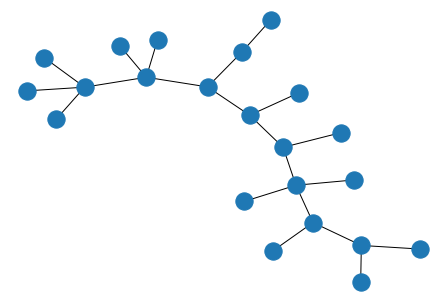

In [ ]:
## Solution (to be removed)
G = dataset[2]
G = to_networkx(G, to_undirected=True)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos)

Let us now visualize the molecules using the `plot_mol` function that we already implemented.

The `interact` widget allows for easy visualization of the different molecules in the dataset: try it out!

In [ ]:
interact(
    lambda graph: plot_mol(
        to_molecule(dataset[graph]),
        edge_type=dataset[graph].edge_attr[:,0].numpy(),
    ),
    graph=range(len(dataset))
)

interactive(children=(Dropdown(description='graph', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,…

<function __main__.<lambda>>

## Batching in Pytorch Geometric
Neural networks typically work on batches of input data. For efficiency reasons, a Pytorch Geometric Dataloader builds a batch of graphs by considering it as a unique big graph: the big graph adjacency matrix is built by stacking diagonally the adjacency matrices of the graphs in the batch (which are defined by `edge_index`); features and target matrices are concatenated in the node dimension. This composition allows differing number of nodes and edges over examples in one batch.

$$  A =
  \begin{bmatrix}
    A_{1} & & \\
    & \ddots & \\
    & & A_{N}
  \end{bmatrix}, \quad X = \begin{bmatrix}
X_1\\ 
\vdots \\ 
X_N
\end{bmatrix}, \quad Y = \begin{bmatrix}
Y_1\\ 
\vdots\\
Y_N
\end{bmatrix}$$

A batch of graphs will contain the `batch` attribute, which is a tensor whose length is equal to the number of nodes in the big graph obtained by the union of all the graphs in the batch. Such tensor maps each node to the index of the graph that nodes originally came from. Thus, this allows for recovering the original graphs from a batch coming form the dataloader.

In [ ]:
from torch_geometric.data import DataLoader

loader = DataLoader(dataset, batch_size=32, shuffle=True)
data_batch = next(iter(loader))
print(data_batch)
print("Number of graphs in the batch:",data_batch.num_graphs)
#print(data_batch.batch)

Batch(batch=[872], edge_attr=[1810, 3], edge_index=[2, 1810], symbols=[32], x=[872, 14], y=[32])
Number of graphs in the batch: 32


# Graph neural networks

How can we operate on graph-structured data in a meaningful way?

Neural networks are typically made of several layers which compute latent representations of the initial input data. The fundamental layer of a GNN is called **graph convolution**. Even though there exists many types of graph convolution, here we will introduce the basic principles on which the idea relies. A graph convolution is a layer that computes the next latent representation of the nodes taking into account the structural information in a meaningful way. In order to understand graph convolution, we first need to understand what are the invariances and properties that a graph neural network should ideally satisfy:

###1) Permutation invariance and equivariance

The idea is very simple. Suppose we want to perform a graph classification task. To work with node features, we typically stack them in a matrix $X \in \mathbb{R}^n\times\mathbb{R}^d$, being $n$ the number of nodes and $d$ the feature dimension. By doing so, we have introduced an ordering of the vertices. For a graph classification task it is clear that changing the vertices ordering (i.e. permuting the vertices) should not change the classification result on the graph. Thus our neural network should be such that it still gives the same result when we consider the graph nodes in a different order. A function that satisfies this property is said to be **permutation invariant**. An example of permutation invariant function is the sum. In formulas, if $P$ is a permutation matrix, $X$ is the feature matrix and $A$ the adjacency matrix of the graph, permutation invariance can be written as 

$$f(X, A) = f(PX, PAP^T).$$

Note that $PX$ indicates the permuted vertices, while $PAP^T$ indicates the corresponding permuted adjacency matrix (in which of course both rows and columns need to be permuted).
Analogously, if we want to perform a node classification task, we would like a permutation of the nodes ordering to be exactly reflected in the result (we want the node predictions to follow the same permutation as the input and not to remain the same, of course). A function that satisfies this property is said to be **permutation equivariant** and in formulas can be written as 

$$f(PX, PAP^T) = P(f(X)).$$

Depending on the specific task (e.g. graph classification or node classification), it may be desirable to have a permutaton invariant, or permutation equivariant neural network. Graph convolution, seen as a way of computing latent representation for each node, should be a permutation equivariant function.


###2)  Locality

As happens for images convolution, graph convolution should exploit the concept of locality, meaning that the features of the nodes in the neighborhood $\mathcal{N}(x_i)$ of the considered node $i$ should influence the computation of its latent representation. The neighboring nodes of a node $i$ are those to which $i$ is connected to through an edge.

## Graph Convolution

Having in mind the desired properties that graph convolution should satisfy, we can conclude that graph convolution should be a function having the following structure

$f(X, A) = \begin{pmatrix}
g(x_1, \mathcal{N}(x_1))\\ 
g(x_2, \mathcal{N}(x_2))\\ 
\dots\\
g(x_N, \mathcal{N}(x_N))\end{pmatrix}.$

Note that $g$ should not depend on the order in which we consider the neighboring nodes, meaning that $g$ must be a permutation invariant function. Furthermore, as happens in classic image convolution, the function $g$ is the same in each row, meaning that the learnable parameters are the same. This dramatically reduces the number of learnable parameters. A function $f$ defined as above takes into account locality and is permutation equivariant.

In this notebook, we introduce one specific example of convolution layer, as proposed by ([Morris et al. (2018)](https://arxiv.org/abs/1810.02244)). The layer works as follows:

$$
\mathbf{x}_v^{(\ell+1)} = \mathbf{W}^{(\ell + 1)}_1 \mathbf{x}_v^{(\ell)} + \mathbf{W}^{(\ell + 1)}_2 \sum_{w \in \mathcal{N}(v)} \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}_i^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]`, for $i \in \{ 1, 2 \}$. Here $\mathbf{x}_v^{(\ell)}$ denotes the latent representation of node $v$ in layer $l$. This formula expresses the function $g$ introduced above. Note that we sum all the feature vectors in the neighborhood of node $i$, which exploits locality and guarantees permutation invariance of $g$.



## Exercise 3

Implement by yourself the graph convolution layer proposed above, by completing the following class. For simplicity, assume we work with a single graph and not a batch of graphs. You ma use the PyTorch Geometric function `to_dense_adj`, which converts an edge index to a dense adjacency matrix that can be used to determine the neighborhood of a node with simple matrix multiplication.

In [ ]:
from torch_geometric.utils import to_dense_adj

In [ ]:
## TODO: Implement me:)
class GraphConvolution(torch.nn.Module):
  def __init__(self, num_input_features, num_output_features):
    super().__init__()
    self.W1 = torch.nn.Linear(num_input_features, num_output_features, bias=False)
    self.W2 = torch.nn.Linear(num_input_features, num_output_features, bias=False)
    
  def forward(self, x, edge_index):
    # Implement me!
    pass




# You may test that your class does not throw errors and
# at least the correctness of dimensionality with the following lines
G = dataset[0]
x = G.x
print(x.shape)

edge_index = G.edge_index
conv = GraphConvolution(14, 8)

out = conv(x, edge_index)

print(out.shape)

torch.Size([35, 14])


In [ ]:
## Solution (to be removed AND ALSO TO BE CHEKED!!)
class GraphConvolution(torch.nn.Module):
  def __init__(self, num_input_features, num_output_features):
    super().__init__()
    self.W1 = torch.nn.Linear(num_input_features, num_output_features, bias=False)
    self.W2 = torch.nn.Linear(num_input_features, num_output_features, bias=False)
    
  def forward(self, x, edge_index):
    adj = to_dense_adj(edge_index)
    neighbors_aggregation = torch.matmul(adj, x)
    out = self.W1(x) + self.W2(neighbors_aggregation)
    return out


torch.Size([35, 14])
torch.Size([1, 35, 8])


## Implementing your first GNN in Pytorch Geometric
Conveniently, the graph convolution layer we have introduced above is implemented in Pytorch Geometric, under the name [`GraphConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GraphConv). We can now use it to build our first graph convolution network!



## Graph-level classification of molecules

We have seen that graph convolution is used to compute latent representation of the nodes in a graph. Depending on the specific task we need to perform, we will then use the last layer latent representations differently. An example is given in the following image.


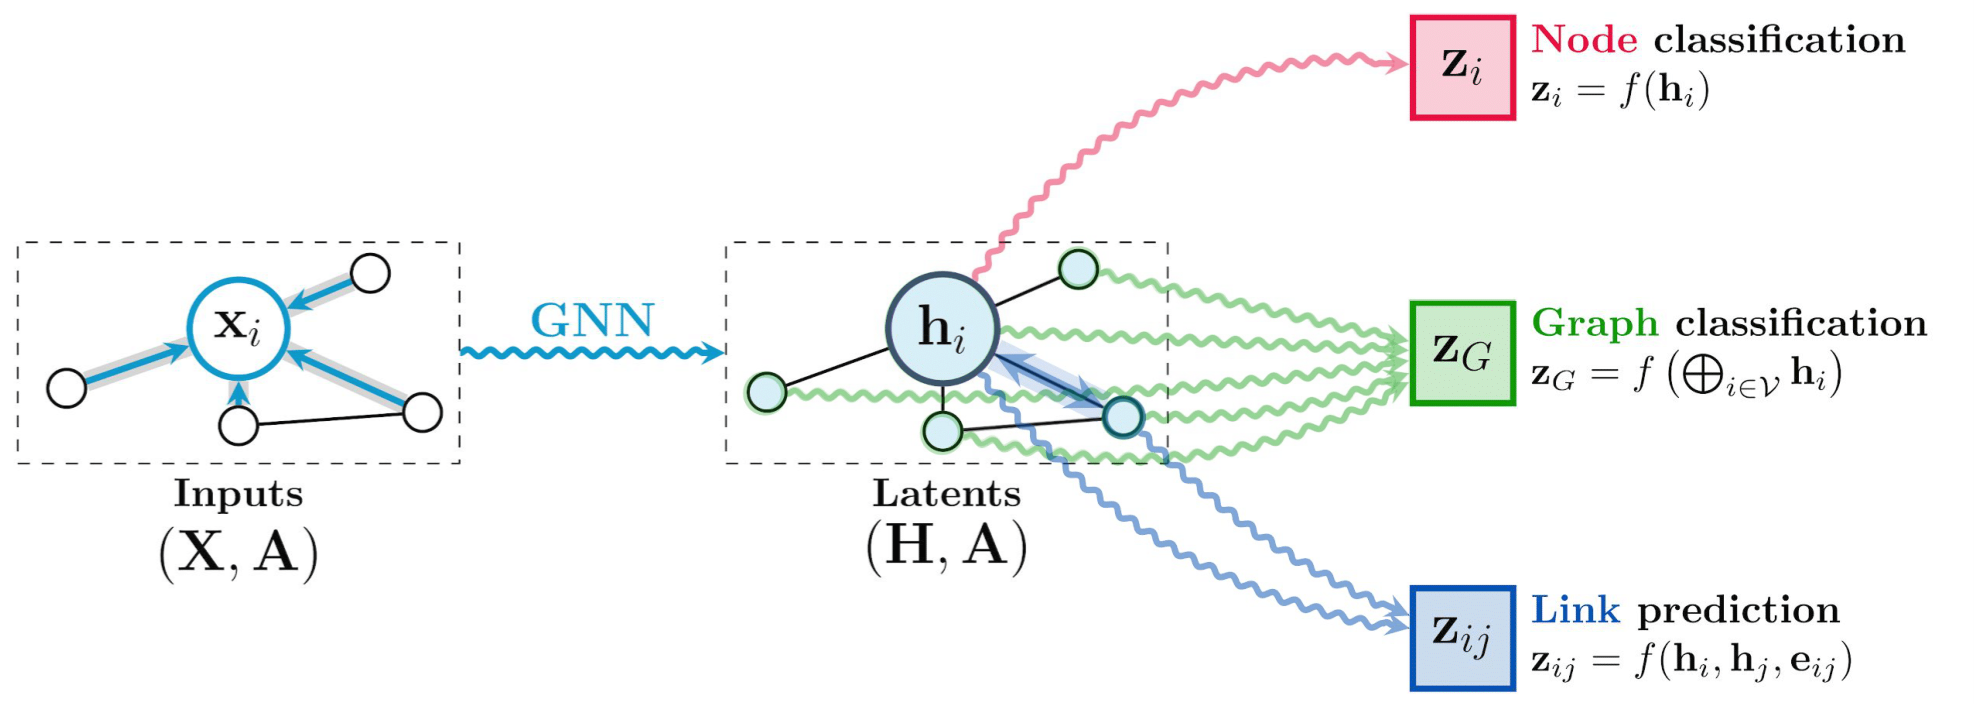

Remember that we are working on a graph classification task on the Mutagenicity dataset. This means that, after applying some convolution layers, we need to aggregate the node latent representations using a permutation invariant function. To this end, we will use the `global_add_pool` function. `global_add_pool` returns graph-level-outputs by adding node features across the node dimension, so that for a single graph $G_i$ its output is computed by
$$r_i = \sum_i ^N x_i.$$ `global_add_pool` takes as input the feature matrix `x` of the big batch graph and the `batch` tensor (see the section "Batching in Pytorch Geometric, above"). The batch tensor is used to correctly aggregate the node features within each graph in the batch.

## Exercise 4 (Network architecture)

Complete the missing parts in the implementation of the following GNN class. Define the convolution layers using the available GraphConv layer and keep the hidden layer feature dimension constant among the convolution layers. We first apply 5 convolutions (a ReLu activation is applied after each convolution). We then perform the `global_add_pool` and add with two fully connected layers with a dropout. Finally, we conclude with a LogSoftmax, so that **our model outputs the log probabilities** of the molecule being or not mutagenetic. we prefer `LogSoftmax` to `SoftMax` since the first is more numerically stable.

In [ ]:
from torch.nn import Linear, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_add_pool

## TODO: Implement me :)
class GNN(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        hidden_dim,
        node_features_dim,
        edge_features_dim=None
    ):
        super(GNN, self).__init__()
        self.hidden_dim = hidden_dim

        # Implement me!
        self.conv1 = 
        self.conv2 = 
        self.conv3 = 
        self.conv4 = 
        self.conv5 = 

        # Implement me!
        self.fc1 = 
        self.fc2 = Linear(hidden_dim, num_classes)

        self.readout = LogSoftmax(dim=-1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        # Implement me!
        x = 
        x = 
        x = 
        x = 
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return self.readout(x)

SyntaxError: ignored

In [ ]:
from torch.nn import Linear, LogSoftmax
import torch.nn.functional as F
from torch_geometric.nn import GraphConv, global_add_pool

## Solution (To be removed)
class GNN(torch.nn.Module):
    def __init__(
        self,
        num_classes,
        hidden_dim,
        node_features_dim,
        edge_features_dim=None
    ):
        super(GNN, self).__init__()
        self.hidden_dim = hidden_dim

        self.conv1 = GraphConv(node_features_dim, hidden_dim)
        self.conv2 = GraphConv(hidden_dim, hidden_dim)
        self.conv3 = GraphConv(hidden_dim, hidden_dim)
        self.conv4 = GraphConv(hidden_dim, hidden_dim)
        self.conv5 = GraphConv(hidden_dim, hidden_dim)

        self.fc1 = Linear(hidden_dim, hidden_dim)
        self.fc2 = Linear(hidden_dim, num_classes)

        self.readout = LogSoftmax(dim=-1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = F.relu(self.conv4(x, edge_index))
        x = F.relu(self.conv5(x, edge_index))
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        
        return self.readout(x)

## Training
We are now ready to train our first GNN!

First, we prepare the dataloaders for train, validation and test data.

In [ ]:
from torch_geometric.data import DataLoader
from tqdm.auto import tqdm

# If possible, we use a GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

idx_train_end = int(len(dataset) * .5)
idx_valid_end =  int(len(dataset) * .7)

BATCH_SIZE = 128
BATCH_SIZE_TEST = len(dataset) - idx_valid_end

# In the test loader we set the natch size to be equal to the size of the whole test set 
loader_train = DataLoader(dataset[:idx_train_end], batch_size=BATCH_SIZE, shuffle=True)
loader_valid = DataLoader(dataset[idx_train_end:idx_valid_end], batch_size=BATCH_SIZE, shuffle=True)
loader_test = DataLoader(dataset[idx_valid_end:], batch_size=BATCH_SIZE_TEST, shuffle=False)

Using device: cuda


We initialize an instance of the GNN model we have defined above. We use negative log likelihood as loss function (`NLLLoss` in Pytorch), and Adam optimizer.

In [ ]:
from torch.nn import NLLLoss

# Model
model = GNN(
    num_classes = 2,
    hidden_dim=64,
    node_features_dim=dataset.num_node_features,
).to(device)

# Optimizer
optimizer = torch.optim.Adam(params=model.parameters())

# Loss function
loss_function = NLLLoss()

Finally, we can define the training loop and train our GNN model!

In [ ]:
def train_model(loader_train, loader_valid, model, optimizer, loss_function, N_EPOCHS):
  # Prepare empy lists for logging
  train_losses = []
  train_accs = []
  val_accs = []

  for epoch in tqdm(range(N_EPOCHS)):
      epoch_loss = 0
      for batch in tqdm(loader_train, leave=False):
          batch.to(device)

          out = model(batch.x, batch.edge_index, batch.batch)
          loss = loss_function(out, batch.y.flatten())

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          acc_train = compute_accuracy(model, loader_train)
          acc_valid = compute_accuracy(model, loader_valid)

          with torch.no_grad():
            train_accs.append(acc_train)
            val_accs.append(acc_valid)
            train_losses.append(loss)

      print(f"Epoch: {epoch}, Loss: {loss}")

  # Visualizatin at the end of training
  fig, ax = plt.subplots(dpi=120)
  ax.plot(train_accs, c="steelblue", label="Training")
  ax.plot(val_accs, c="orangered", label="Validation")
  ax.grid()
  ax.legend()
  plt.show()


Epoch: 0, Loss: 0.8000761270523071


Epoch: 1, Loss: 0.6280001997947693


Epoch: 2, Loss: 0.6118778586387634


Epoch: 3, Loss: 0.553135871887207


Epoch: 4, Loss: 0.4941093325614929



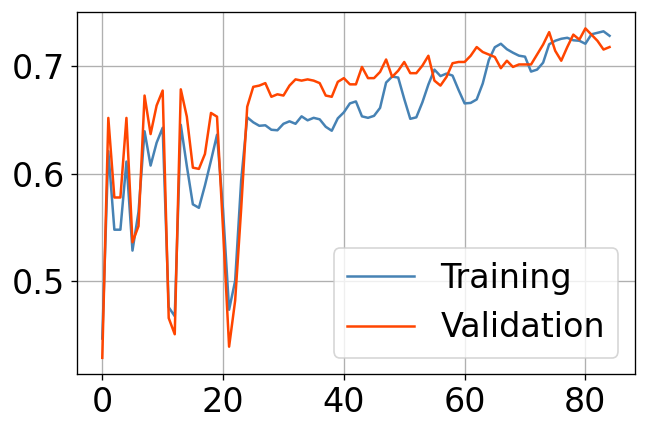

In [ ]:
N_EPOCHS = 5
train_model(loader_train, loader_valid, model, optimizer, loss_function, N_EPOCHS)

## Evaluation

We can now see how our trained model performs on the test data and plot the corresponding confusion matrix.

## Exercise 5
Compute the test confusion matrix and plot it. Remember that we set the `test_loader` batch size t obe equal to the whole test set length. For computing the confusion matrix you may use the sklearn [`confusion_matrix`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) method, and you can plot it with [`ConfusionMatrixDisplay`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html).

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Compute and plot the test confusion matrix!

You can check your results by running the following cell. You can find the implementation of the simple functions `compute_cm` and `plot_cm` in the script `visualization.py`.

Accuracy: 0.55


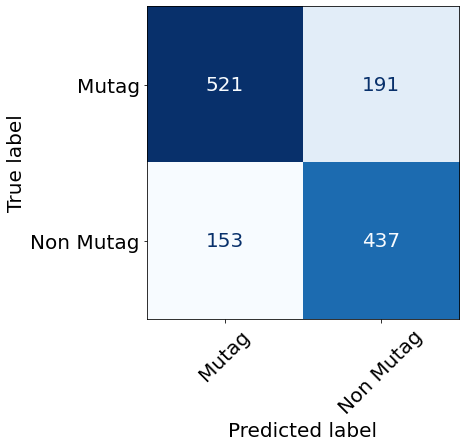

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute cm
cm = compute_cm(model, loader_test)

# Plot cm
plot_cm(cm)

print(f"""Accuracy: {round(((y_true.flatten().cpu() == y_pred.cpu()).sum() /
                            len(y_pred)).item(), 2)}""")

The confusion matirx looks pretty good.

In this first part of the notebook, you have learned how to work with graphs in PyTorch Geometric. You have learned the fundamental principles underlying graph convolution and implemented and trained a simple GNN.

In the second part of this workshop, we are going to talk about explanability: why is the model predicting what it's predicting?

# Explainability

Let's try to **gain insight** from our trained model.

Ideally, we would like to be able to **infer why** does the model predict a certain output for a given input.
In particular, since we are working with _graphs_, we are interested in the **structural properties** that influence most the outcome.

To this end, Ying, Rex et al. designed [GNN Explainer][1], a general,  model-agnostic approach for providing interpretable explanations for predictions of any GNN-based model on any graph-based machine learning task.

> Ying, Rex, et al. ["Gnnexplainer: Generating explanations for graph neural networks."][1] Advances in neural information processing systems 32 (2019): 9240.

---

This second half of the workshop is structured as follows:

1. Brief **theoretical motivation** of GNN Explainer
1. **Coding** the  for graph classification 
1. Explain the reults of the GNN model on molecules from **Mutagenicity**

[1]: https://github.com/RexYing/gnn-model-explainer
[1]: https://arxiv.org/abs/1903.03894


## GNN-explainer

Ying, Rex et al. proposed GNN EXPLAINER , an approach for explaining
predictions made by GNNs.
GNN EXPLAINER **takes a trained GNN and its prediction**, and it **returns an
explanation** in the form of a small **subgraph** of the input graph together
with a small **subset of node features** that are most influential for the
prediction.

### HOW?

They try to maximize the **mutual information** ($MI$) with GNN's prediction $Y$
by optimizing a **subgraph** $G_S$ (to select the important subgraphs) and a
**feature mask** $X_S$: 

$$
    \underset{G_S}{\max} (Y, (G_S, X_S)) =
    H(Y) - H(y | G = G_S, X=X_S),
$$
where $H$ denotes entropy.

This obective is intractable (exponentially many subgraphs).
The authors propose a _relaxation_ and change the conditional entropy with a
**cross entropy**.
The objective becomes to learn a **graph mask** $M \in \mathbb{R}^{n \times n}$, and since $H(Y)$ is independent from the masks, our objective becomes to minimize the following:

$$
    \underset{M}{\min} -\sum_{c=1}^C \mathbf{1}_{y = c}
    \log P_{\Phi}(Y = y | G = A_c \odot \sigma(M), X = X_c).
$$

On top of that, we include constraints on the size of the mask and on the feature selector. These will be additional term in the loss function.

1. Constraint on the graph size: $\lambda_1 \| A_c \odot \sigma(M) \|_1$
1. Constraint on the graph entropy:
$ \lambda_2 H \big( A_c \odot \sigma(M) \big)$ 
1. Constraint on the number of features: $\lambda_3 \| X_c \|_1$

## Exercise 6

Write down the explainer loss function as explained above. As explained, the loss will be weighted sum of four terms.

In [ ]:
# TODO: implement me! :)
def graph_loss(
    x: torch.tensor,
    edge_index: torch.tensor,
    batch_index: torch.tensor,
    expl_label: int,
    **kwargs
) -> torch.tensor:
    """Computes the explainer loss function for explanation
    of graph classificaiton tasks.

    Returns:
        loss (torch.tensor): explainer loss function, which
            is a weight sum of different terms.
    """
    # We randomly initialize the masks
    (N, F), E = x.size(), edge_index.size(1)

    node_feat_mask = torch.nn.Parameter(torch.randn(F) * 0.1)
    self.edge_mask = torch.nn.Parameter(torch.randn(E) * 0.01)

    # Get model predictions
    # NOTE: Suppose the edge mask is implicitly applied,
    # you only have to use the feature mask.

    # Prediction loss.

    # Edge mask size loss.

    # Edge mask entropy loss.

    # Feature mask size loss.

    raise NotImplementedError()


TODO: add a brief presentation for the GNNExplainer class we implemented. We can either

1)show the entire class in a cell (meybe it's too long for a notebook?)

2) Show only the correct loss or only the traininggraph, and explain the signature in the text here

3) avoid to show the class and simply explain how it should be initialized 

## Exercise 7

Choose one graph from the dataset and compute its explanation (i.e. the feature and edge mask). Finally, the explanation is visualized using the `plot_mol` function.

In [ ]:
# Take a graph
data = dataset[0]
data.to(device)

# TODO: Initialize explainer
explainer = 

# TODO: Train explainer
GNNExp_feat_mask, GNNExp_edge_mask = 



# Plot the explanation
mol = to_molecule(data)

GNNExp_edge_mask_dict = mask_to_dict(
    GNNExp_edge_mask,
    data
)
plot_mol(mol, edge_mask=GNNExp_edge_mask_dict)

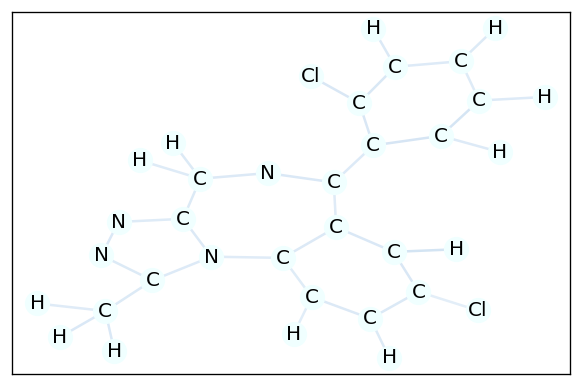

In [ ]:
# Solution: (to be removed)
data = dataset[0]
data.to(device)

# Initialize explainer
explainer = GNNExplainer(model, epochs=200).to(device)

# Train explainer
model_args = (
    data.x,
    data.edge_index,
    torch.zeros(data.num_nodes, dtype=int, device=device)
)

GNNExp_feat_mask, GNNExp_edge_mask = explainer.explain_graph(
    *model_args,
    model(*model_args).argmax(dim=1)
)

mol = to_molecule(data)

GNNExp_edge_mask_dict = mask_to_dict(
    GNNExp_edge_mask,
    data
)
plot_mol(mol, edge_mask=GNNExp_edge_mask_dict)

## Interactive analysis

We can now interectively visualize and comment the results for our GNN Explainer. We implemented the `big_interact` function (TODO:change name), which allows you to choose which samples to visualize (true positive, false positives,...), and to interactively change the threshold for the explanation visualization. You will see that `GNNExplainer` correclty individuates explatations for its predictions: from domain knowledge we know for example that NO2 and NH2 groups are important for predicting the mutagenicity of a molecule and GNNExplainer correctly identifies these groups.

Try it out!

In [ ]:
interact(
    big_interact,
    which=["true_pos", "true_neg", "false_pos", "false_neg"]
)

interactive(children=(Dropdown(description='which', options=('true_pos', 'true_neg', 'false_pos', 'false_neg')…

<function __main__.big_interact>